In [28]:
from rule_generation import * 

### Carregando a base de dados de interesse

Mude a base de dados de acordo com o nome sorteado.

In [29]:
df_name = 's_temp_ubatuba.csv'
df = pd.read_csv(df_name)
df.drop(columns='time', inplace=True)

Transformando a série temporal em uma base de dados com lags.

In [30]:
max_lagged = 3 #aqui seria o número de conjuntos -1, entao eu tenho 2 conjuntos

df = df[['value']].copy()
df.columns = ['target']
for i in range(1, max_lagged):
    df[f'lag_{i}'] = df['target'].shift(i)
df.dropna(inplace=True)

df = df.iloc[:, ::-1]

### Criando a variável linguística para cada um dos lags do problema. 

Nessa etapa, crie e modifique as variáveis linguísticas (e seus respectivos conjuntos Fuzzy) para chegar a uma melhor resposta. 

Abaixo tem uma ideia de como criar essa lista de variáveis linguísticas de uma forma enxuta e rápida. Contudo, tente você também fazer suas adaptações.

In [31]:
min_value = min(df.min())
max_value = max(df.max())

num_fuzzy_sets = 7       #num de conjuntos fuzzy
use_linspace = False        # False = arange, True = linspace
use_product_and = True     # True = produto, False = min
use_product_imp = True     # True = produto, False = min
defuzz_method = "centroid" # opções: centroid, bisector, mom, som, lom

if use_linspace:
    universe = np.linspace(min_value, max_value, 100)
else:
    universe = np.arange(min_value - 1, max_value + 1, 1)

variable_list = [
    ctrl.Antecedent(universe, name) if name != 'target'
    else ctrl.Consequent(universe, name)
    for name in df.columns
]

for variable in variable_list:

    variable.automf(num_fuzzy_sets)

    # AND
    if use_product_and:
        variable.and_func = np.multiply
    else:
        variable.and_func = np.fmin

    # Implicação
    if use_product_imp:
        variable.implication = np.multiply
    else:
        variable.implication = np.fmin

    # Defuzzificação apenas no target
    if variable.label == "target":
        variable.defuzzify_method = defuzz_method


### Divisão da base de dados (treino e teste)

In [32]:
# Split between train and test dataframes
train_df = df.iloc[:int(len(df) * 0.9)]
test_df = df.iloc[int(len(df) * 0.9):]

### Criando o sistema Fuzzy usando o método Wang-Mendel

In [33]:
fuzzy_system = create_fuzzy_system(train_df, variable_list, 1)


/workspaces/ELE2399-Trabalho1/rule_generation.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label, p = select_higher_membership(list_variables[i], list_values[i])
/workspaces/ELE2399-Trabalho1/rule_generation.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label, p, select_higher_membership(list_variables[i+k+1], list_values[i+k+1])


### Fazendo a previsão para o conjunto de treino e de teste.

In [34]:
def predict(df):
    df_copy = df.copy()
    df_copy.loc[:, 'predict'] = np.nan
    # Create a loop to predict the values 
    for i in range(len(df_copy)):
        l = df_copy.iloc[i,:].shape[0] - 2
        for k in range(l):
            fuzzy_sim.input[f'lag_{l - k}'] = df_copy.iloc[i, k]
        try:
            fuzzy_sim.compute()
            out = fuzzy_sim.output['target']
        except:
            out = df_copy.iloc[i, k]
        df_copy.iloc[i, l + 1] = out 
    return df_copy 

In [35]:
fuzzy_sim = ctrl.ControlSystemSimulation(fuzzy_system)

predict_train_df = predict(train_df)

In [36]:
predict_test_df = predict(test_df)

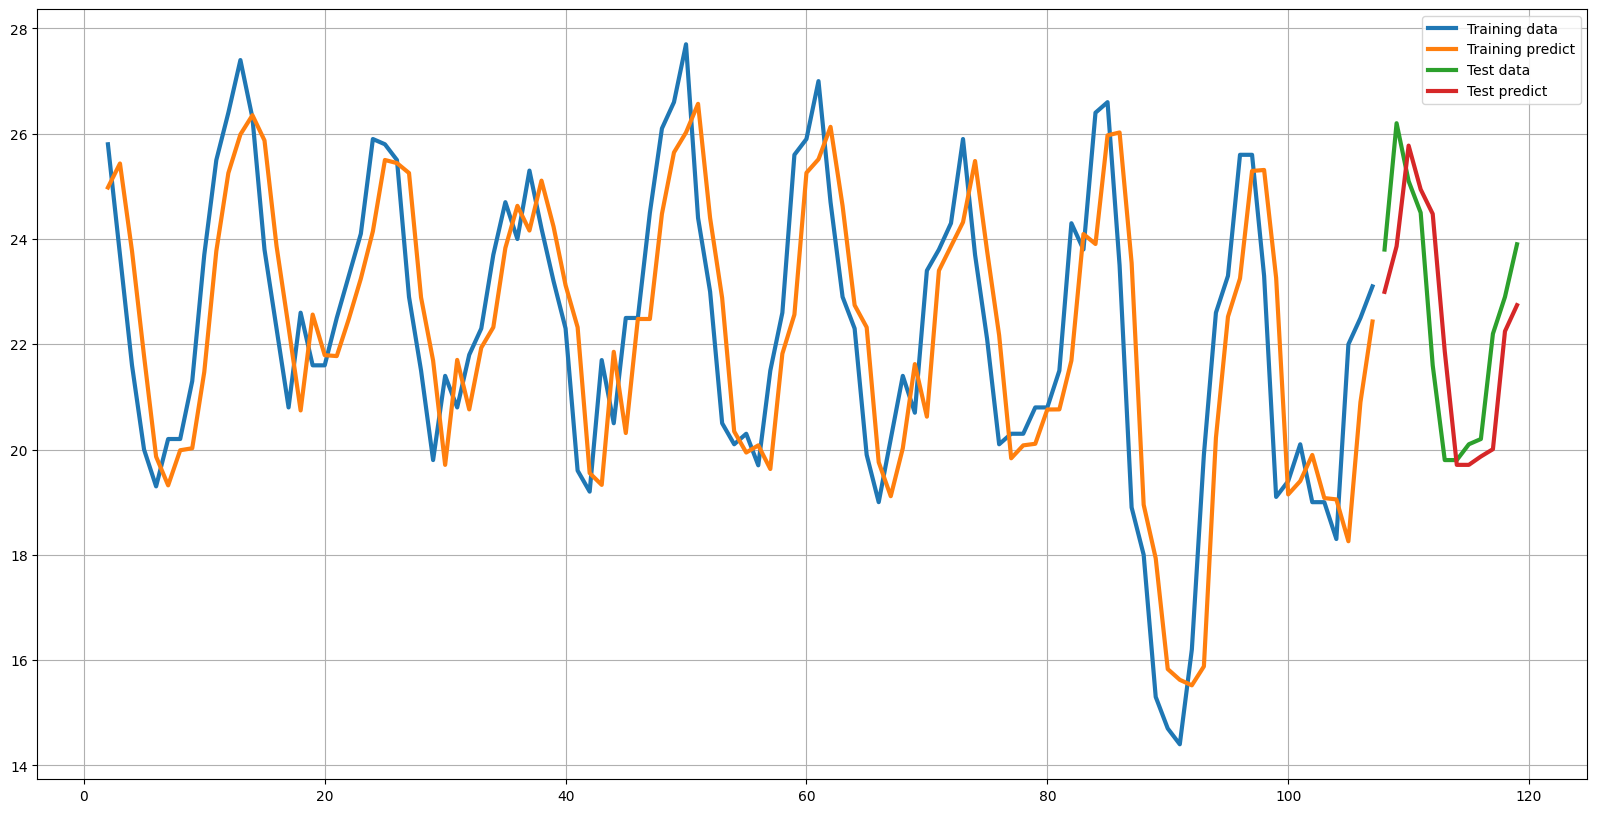

In [37]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(20, 10))
plt.plot(predict_train_df['target'], label='Training data', linewidth=3)
plt.plot(predict_train_df['predict'], label='Training predict', linewidth=3)
plt.plot(predict_test_df['target'], label='Test data', linewidth=3)
plt.plot(predict_test_df['predict'], label='Test predict', linewidth=3)
plt.legend()
plt.grid()

plt.show()

In [ ]:
#aqui eu to criando um csv para usar como base para criar as regras
#no caso eu tenho 2 conjuntos de entrada e 1 de saida, cada conjunto tem 7 categorias 

variables = {}
for col in df.columns:
    vmin, vmax = df[col].min(), df[col].max()

    if col != "target":
        var = ctrl.Antecedent(np.linspace(vmin, vmax, 500), col)
    else:
        var = ctrl.Consequent(np.linspace(vmin, vmax, 500), col)

    var.automf(num_fuzzy_sets)  # cria: poor, mediocre, average, decent, good
    variables[col] = var

labels = ["dismal", "poor", "mediocre", "average", "decent", "good", "excellent"]

rows = []

for idx in range(10):  # primeiros 10 registros
    row = {"index": idx}
    for col in df.columns:
        x = df.iloc[idx][col]
        var = variables[col]

        for lb in labels:
            mf = var[lb].mf
            mu = fuzz.interp_membership(var.universe, mf, x)
            row[f"{col}_{lb}"] = mu

    rows.append(row)

result_df = pd.DataFrame(rows)
result_df.to_csv("membership_first10.csv", index=False)
print("CSV gerado: membership_first10.csv")

CSV gerado: membership_first10.csv


## Segunda parte do trabalho

### Devemos extrair regras das primeiras dez entradas, o nosso passo a passo será:

1. Para cada entrada

2. Gerar a regra apartir dos pesos gerados por uma entrada

3. Verificar se essa regra bate com alguma outra já existente

4. Explicitar as regras finais

### Como esses são os labels para os 2 conjuntos entrada e o de saida ["dismal", "poor", "mediocre", "average", "decent", "good", "excellent"], irei utilizar para a criação de regras o seguinte formato, essa regra vale para todas as labels.

- L2D - Lag 2 Dismal
- L1D - Lag 1 Dismal
- TD - Target Dismal


In [ ]:
#Irei aproximas os graus de pertencimento de cada entrada.

# ENTRADA 1
uL2G = 0.27
uL2E = 0.73

uL1D = 0.08
uL1G = 0.92

uTG = 0.86
uTE = 0.14

# agora que os graus de pertencimento estão evidenciados 
# vou criar as regras com maior peso possivel, multiplicando os u

w1 = uL2G * uL1D * uTG 
w2 = uL2G * uL1G * uTG
w3 = uL2E * uL1D * uTG
w4 = uL2E * uL1G * uTG

# ENTRADA 2

uL2D = 0.08
uL2G = 0.92

uL1G = 0.85
uL1E = 0.15

uTD = 0.80
uTG = 0.20

w5 = uL2D * uL1G * uTD     
w6 = uL2D * uL1E * uTD     
w7 = uL2G * uL1G * uTD    
w8 = uL2G * uL1E * uTD     

# ENTRADA 3

uL2G = 0.85
uL2E = 0.15

uL1D = 0.80
uL1G = 0.20

uTA = 0.75
uTD = 0.25

w9  = uL2G * uL1D * uTA 
w10 = uL2G * uL1G * uTA 
w11 = uL2E * uL1D * uTA 
w12 = uL2E * uL1G * uTA 

# ENTRADA 4
uL2D = 0.80
uL2G = 0.20

uL1A = 0.75
uL1G = 0.25

uTM = 0.48
uTA = 0.52

w13 = uL2D * uL1A * uTA   
w14 = uL2D * uL1G * uTA   
w15 = uL2G * uL1A * uTA   
w16 = uL2G * uL1G * uTA   

# ENTRADA 5
uL2A = 0.75
uL2D = 0.25

uL1M = 0.48
uL1A = 0.52

uTM = 0.79
uTA = 0.21

w17 = uL2A * uL1M * uTM  
w18 = uL2A * uL1A * uTM  
w19 = uL2D * uL1M * uTM  
w20 = uL2D * uL1A * uTM  

# ENTRADA 6

# ENTRADA 7

# ENTRADA 8

# ENTRADA 9

# ENTRADA 10

